# Load the RDF data dump

In [19]:
%%time
from rdflib import ConjunctiveGraph

ns = {"nb": "http://bise-eu.info/core-ontology#",
      "dc": "http://dcterms/",
      "p-plan": "http://purl.org/net/p-plan#",
      "edam": "http://purl.obolibrary.org/obo/edam#"}

g = ConjunctiveGraph()

### latest version of the RDF dataset dump
g.parse("https://raw.githubusercontent.com/bio-tools/content/master/datasets/bise-ontology-biii-dump.ttl", format="turtle")
g.parse("bise-linked-data-webapp/static/data/EDAM-bioimaging_alpha03.owl")
print(str(len(g)) + ' triples in Biii data graph')

27864 triples in Biii data graph
CPU times: user 1.45 s, sys: 40.5 ms, total: 1.49 s
Wall time: 1.81 s


# Critical Entries +++

In [21]:
%%time
# Entries without authors and without download link
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/software> .
    FILTER ( NOT EXISTS {?s nb:hasAuthor ?author} 
          && NOT EXISTS {?s nb:hasLocation ?location} ).
}
"""
no_authors_no_link = ""
results = g.query(q, initNs=ns)
for r in results:
    print('No author and no download link: ' + str(r["nb_soft"]))
    no_authors_no_link = r["nb_soft"]

    
# Entries with missing authors or download link
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/software> .
    FILTER ( NOT EXISTS {?s nb:hasAuthor ?author} 
          || NOT EXISTS {?s nb:hasLocation ?location} ).
}
"""
no_authors_no_link = ""
results = g.query(q, initNs=ns)
for r in results:
    print('Missing authors or download link: ' + str(r["nb_soft"]))
    no_authors_no_link = r["nb_soft"]
    

# Entries without any EDAM operation
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/software> .
    FILTER ( NOT EXISTS {?s nb:hasFunction ?function} 
          && NOT EXISTS {?s nb:hasTopic ?topic} ).
}
"""
no_EDAM = ""
results = g.query(q, initNs=ns)
for r in results:
    print('No EDAM annotations: ' + str(r["nb_soft"]))
    no_EDAM = r["nb_soft"]

    
# Entries without license
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/software> .
    FILTER ( NOT EXISTS {?s nb:hasLicense ?license} ).
}
"""
no_License = ""
results = g.query(q, initNs=ns)
for r in results:
    print('No License (free text): ' + str(r["nb_soft"]))
    no_License = r["nb_soft"]

No author and no download link: 115
Missing authors or download link: 533
No EDAM annotations: 319
No License (free text): 1055
CPU times: user 1.04 s, sys: 9.52 ms, total: 1.05 s
Wall time: 1.05 s


In [22]:
%%time
q = """
SELECT ?label (count(distinct ?s1) as ?soft_count) WHERE { 
    ?s1 a <http://biii.eu/software> .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?edam_class .
    ?edam_class rdfs:label ?label
}
GROUP BY ?edam_class ?label
ORDER BY DESC(?soft_count)
"""

results = g.query(q, initNs=ns)

for r in results:
    print (r["label"] + " : " + r["soft_count"])

Bioimage informatics : 505
Fluorescence microscopy : 88
Machine learning : 67
Imaging : 55
Digital histology : 40
Microscopy : 39
Data sharing : 35
Statistics : 31
Electron microscopy : 28
Light-sheet microscopy : 21
High content screening : 19
Light microscopy : 19
Confocal microscopy : 17
Super-resolution microscopy : 16
Confocal fluorescence microscopy : 15
Single molecule localization microscopy : 15
Live sample imaging : 13
Bright field microscopy : 13
Magnetic resonance imaging : 10
Widefield microscopy : 9
Phase contrast microscopy : 9
Tomography : 6
Correlative Light and Electron Microscopy : 6
Supervised learning : 6
Structured illumination microscopy : 6
Serial block-face scanning electron microscopy : 4
In-silico reconstruction : 4
Topic : 3
Fluorescence correlative spectroscopy : 3
Focused ion beam scanning electron microscopy : 3
Computerized tomography : 3
Multi-photon microscopy : 3
Scanning electron microscopy : 3
Electron tomography : 2
In-vivo imaging : 2
Fluctuation 

## Count the number of tools without any reference publication

In [23]:
%time
no_doi_query = """
SELECT ?s (count(?title) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/software> .
    ?s dc:title ?title .
    FILTER NOT EXISTS {?s nb:hasReferencePublication ?publication} .
}
"""
results = g.query(no_doi_query, initNs=ns)
for r in results:
    print(r["nb_soft"])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
973


## Count the number of tools with a reference publication

In [24]:
%%time
doi_query = """
SELECT ?s (count(?title) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/software> .
    ?s dc:title ?title .
    ?s nb:hasReferencePublication ?publication .
}
"""
results = g.query(doi_query, initNs=ns)
for r in results:
    print(r["nb_soft"])

757
CPU times: user 58.9 ms, sys: 2.33 ms, total: 61.3 ms
Wall time: 60.7 ms


In [25]:
%%time
how_many_tools_per_topic = """
SELECT ?label (count(distinct ?s1) as ?soft_count) WHERE { 
    ?s1 a <http://biii.eu/software> .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?edam_class .
        
    ?edam_class rdfs:label ?label .
}
GROUP BY ?edam_class ?label
ORDER BY DESC(?soft_count)
"""

results = g.query(how_many_tools_per_topic, initNs=ns)
for r in results:
    print(r["label"] + " : " + r["soft_count"])

Bioimage informatics : 505
Fluorescence microscopy : 88
Machine learning : 67
Imaging : 55
Digital histology : 40
Microscopy : 39
Data sharing : 35
Statistics : 31
Electron microscopy : 28
Light-sheet microscopy : 21
High content screening : 19
Light microscopy : 19
Confocal microscopy : 17
Super-resolution microscopy : 16
Confocal fluorescence microscopy : 15
Single molecule localization microscopy : 15
Live sample imaging : 13
Bright field microscopy : 13
Magnetic resonance imaging : 10
Widefield microscopy : 9
Phase contrast microscopy : 9
Tomography : 6
Correlative Light and Electron Microscopy : 6
Supervised learning : 6
Structured illumination microscopy : 6
Serial block-face scanning electron microscopy : 4
In-silico reconstruction : 4
Topic : 3
Fluorescence correlative spectroscopy : 3
Focused ion beam scanning electron microscopy : 3
Computerized tomography : 3
Multi-photon microscopy : 3
Scanning electron microscopy : 3
Electron tomography : 2
In-vivo imaging : 2
Fluctuation 

In [26]:
%%time
how_many_tools_per_operation = """
SELECT ?label (count(distinct ?s1) as ?soft_count) WHERE { 
    ?s1 a <http://biii.eu/software> .
    ?s1 <http://bise-eu.info/core-ontology#hasFunction> ?edam_class .
        
    ?edam_class rdfs:label ?label .
}
GROUP BY ?edam_class ?label
ORDER BY DESC(?soft_count)
"""

results = g.query(how_many_tools_per_operation, initNs=ns)
for r in results:
    print(r["label"] + " : " + r["soft_count"])

Image segmentation : 116
Data handling : 82
Image processing : 73
Visualisation : 70
Image analysis : 69
Image visualisation : 60
Cell segmentation : 56
Object detection : 53
Image registration : 52
Object tracking : 51
Analysis : 44
Filament tracing : 42
Image annotation : 41
Spot detection : 40
Object feature extraction : 40
Image generation : 40
Morphological operation : 37
Neuron image analysis : 32
Image thresholding : 30
Cell tracking : 25
Image deconvolution : 24
Isolated object detection : 24
Colocalisation analysis : 23
Isolated object classification : 23
Image enhancement : 23
Object counting : 22
Interactive segmentation : 22
Shape features : 20
Annotation : 20
Image denoising : 20
Watershed : 19
Rigid registration : 19
Alignment construction : 19
Particle tracking : 18
Pixel classification : 18
Image correction : 18
Image stitching : 18
Active contours : 17
Volume rendering : 17
Image classification : 17
Editing : 17
Smoothing : 17
Image reconstruction : 16
Frequency analys

# Count the number of tool for 2018

In [27]:
%%time
date_query = """
SELECT (count(?soft) as ?nb_soft) WHERE {
    ?soft a <http://biii.eu/software> .
    ?soft dc:created ?date .
    FILTER ((?date > "2018-01-01T00:00:00"^^xsd:dateTime) 
            && (?date < "2019-01-01T00:00:00"^^xsd:dateTime))
}
"""
results = g.query(date_query, initNs=ns)
for r in results:
    print('{} registered softwares in 2018'.format(r['nb_soft']))
#    print(r["label"] + " : " + r["soft_count"])
print()


169 registered softwares in 2018

CPU times: user 211 ms, sys: 2.95 ms, total: 214 ms
Wall time: 213 ms


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<AxesSubplot:xlabel='created'>

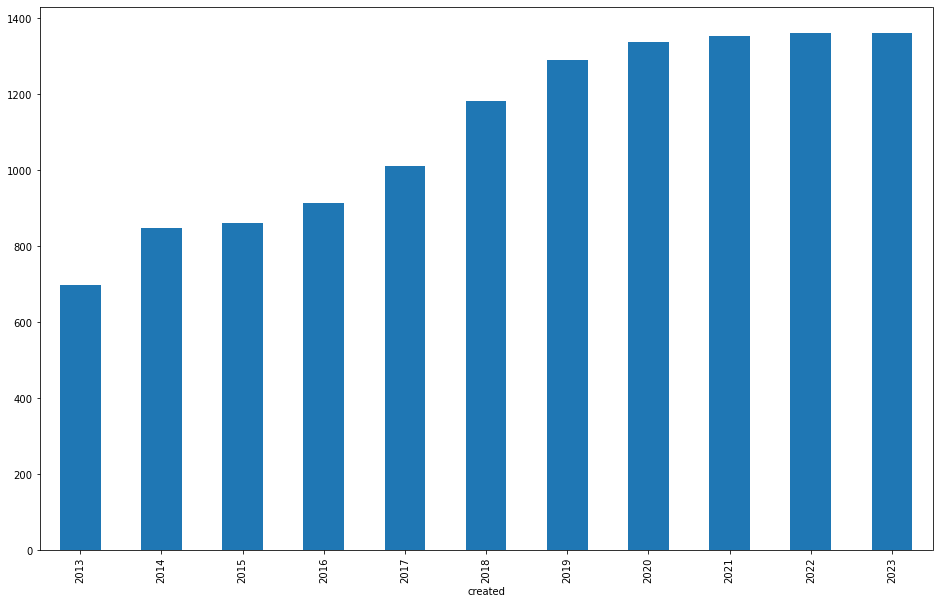

In [36]:
%matplotlib inline

plt.figure(figsize=(16, 10))
#plt.figure(figsize=(9, 6))

soft_dates = []
date_query = """
SELECT ?soft ?date WHERE {
    ?soft a <http://biii.eu/software> .
    ?soft dc:created ?date .
}
"""
results = g.query(date_query, initNs=ns)
for r in results:
    soft_dates.append({'soft':str(r['soft']), 'created':str(r['date'])})

df = pd.DataFrame(soft_dates)
df["created"] = df["created"].astype("datetime64")

#df2 = df.groupby([df["created"].dt.year, df["created"].dt.month]).count()
df2 = df.groupby([df["created"].dt.year]).count()

df2['soft'].cumsum().plot(kind='bar')

In [39]:
import seaborn as sns

per_year_df = df.groupby([df["created"].dt.year]).count()[['soft']]
per_year_df.to_csv('counts_per_year.csv')
per_year_df

#sns.countplot(per_year_df['soft'])

,soft
created,
2013,697
2014,150
2015,13
2016,53
2017,99
2018,169
2019,108
2020,47
2021,18


Ideas of plots : 
 - cumulative stacked hostogram with : "no EDAM annotation" / "some EDAM annotatino" to show that we improvve the quality of tool descriptions
 - same thing with 4-5 categories for the main Topics
 - same thing Tools VS Traing material
 - Open Source VS Comercial softwares 
 

In [40]:
#%%time
#get the main Topics
how_many_tools_per_topic = """
SELECT ?l (count(distinct ?s1) as ?soft_count) WHERE { 
#SELECT ?subclass WHERE { 
    ?s1 a <http://biii.eu/software> .
    ?c rdfs:subClassOf <http://edamontology.org/topic_0003> .
    ?c rdfs:label ?l .
    ?subclass rdfs:subClassOf* ?c .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?subclass .
}
GROUP BY ?c ?l
ORDER BY DESC(?soft_count)
"""

list_of_topics = []
results = g.query(how_many_tools_per_topic, initNs=ns)
for r in results:
    list_of_topics.append({'Topic':str(r['l']), 'Count':str(r['soft_count'])})   
#print(list_of_topics)

df = pd.DataFrame(list_of_topics)
df

,Topic,Count
0,Bioimage informatics,505
1,Imaging,291
2,Machine learning,70
3,Digital histology,40
4,Data sharing,35
5,Statistics,31
6,High content screening,19
7,In-silico reconstruction,4


In [41]:
#%%time
#get the main Operations
how_many_tools_per_op = """
SELECT ?l (count(distinct ?s1) as ?soft_count) WHERE { 
#SELECT ?subclass ?l WHERE { 
    ?s1 a <http://biii.eu/software> .
    ?c rdfs:subClassOf <http://edamontology.org/operation_0004> .
    ?c rdfs:label ?l .
    ?subclass rdfs:subClassOf* ?c .
    ?s1 <http://bise-eu.info/core-ontology#hasFunction> ?subclass .
}
GROUP BY ?c ?l
ORDER BY DESC(?soft_count)
"""

list_of_op = []
results = g.query(how_many_tools_per_op, initNs=ns)
for r in results:
    list_of_op.append({'Operation':str(r['l']), 'Count':str(r['soft_count'])})

df = pd.DataFrame(list_of_op)
df

,Operation,Count
0,Analysis,543
1,Image processing,355
2,Generation,130
3,Visualisation,128
4,Data handling,97
5,Alignment construction,74
6,Classification,62
7,Annotation,54
8,Conversion,14
9,Prediction and recognition,13


In [42]:
#%%time
list_tools_op_topic = """
SELECT ?s1 ?ol ?tl WHERE { 
    ?s1 a <http://biii.eu/software> .
    ?oc rdfs:subClassOf <http://edamontology.org/operation_0004> .
    ?oc rdfs:label ?ol .
    ?osc rdfs:subClassOf* ?oc .
    ?s1 <http://bise-eu.info/core-ontology#hasFunction> ?osc .
    
    ?tc rdfs:subClassOf <http://edamontology.org/topic_0003> .
    ?tc rdfs:label ?tl .
    ?tsc rdfs:subClassOf* ?tc .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?tsc .
}
"""
tools = []
results = g.query(list_tools_op_topic, initNs=ns)
for r in results:
    t = {'tool':str(r['s1']), 'operation': str(r['ol']),'topic': str(r['tl'])}
    #print(t)
    tools.append(t)

[Text(0, 0, 'Annotation'),
 Text(1, 0, 'Visualisation'),
 Text(2, 0, 'Data handling'),
 Text(3, 0, 'Prediction and recognition'),
 Text(4, 0, 'Alignment construction'),
 Text(5, 0, 'Analysis'),
 Text(6, 0, 'Classification'),
 Text(7, 0, 'Generation'),
 Text(8, 0, 'Conversion'),
 Text(9, 0, 'Image processing'),
 Text(10, 0, 'Clustering'),
 Text(11, 0, 'Optimisation or refinement'),
 Text(12, 0, 'Validation')]

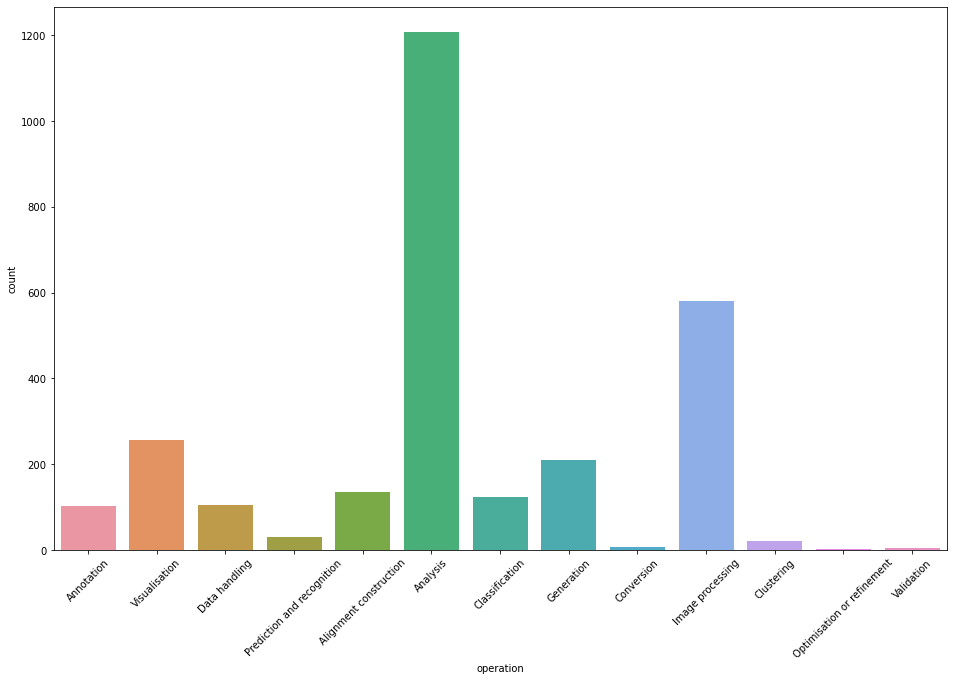

In [44]:
plt.figure(figsize=(16, 10))

df = pd.DataFrame(tools)
chart = sns.countplot(x="operation", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'Machine learning'),
 Text(1, 0, 'Bioimage informatics'),
 Text(2, 0, 'Imaging'),
 Text(3, 0, 'Data sharing'),
 Text(4, 0, 'Digital histology'),
 Text(5, 0, 'High content screening'),
 Text(6, 0, 'In-silico reconstruction'),
 Text(7, 0, 'Statistics')]

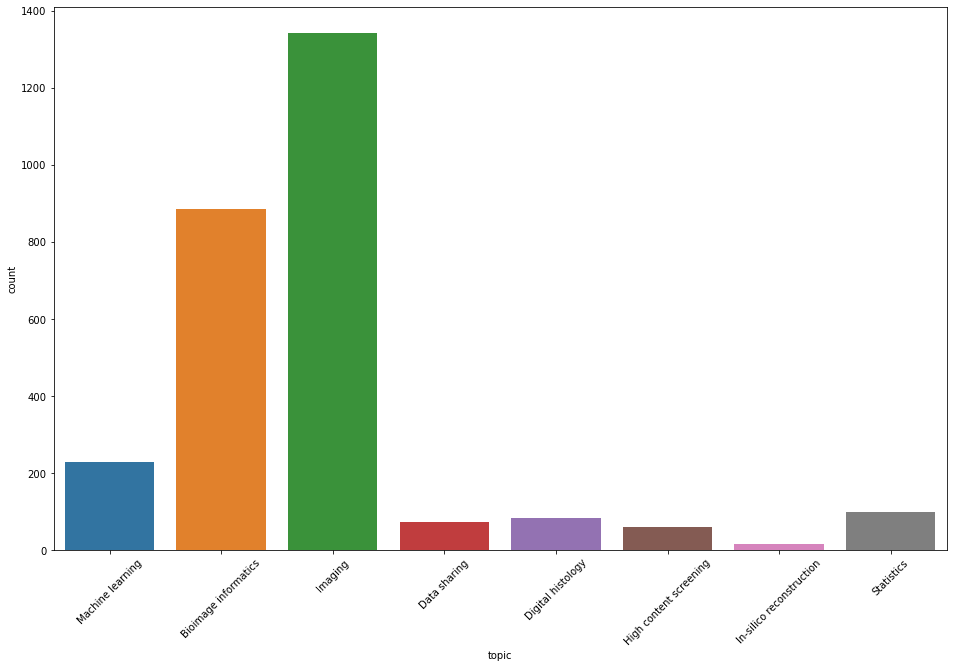

In [45]:
plt.figure(figsize=(16, 10))

df = pd.DataFrame(tools)
chart = sns.countplot(x="topic", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0.5, 0, 'Bioimage informatics'),
 Text(1.5, 0, 'Data sharing'),
 Text(2.5, 0, 'Digital histology'),
 Text(3.5, 0, 'High content screening'),
 Text(4.5, 0, 'Imaging'),
 Text(5.5, 0, 'In-silico reconstruction'),
 Text(6.5, 0, 'Machine learning'),
 Text(7.5, 0, 'Statistics')]

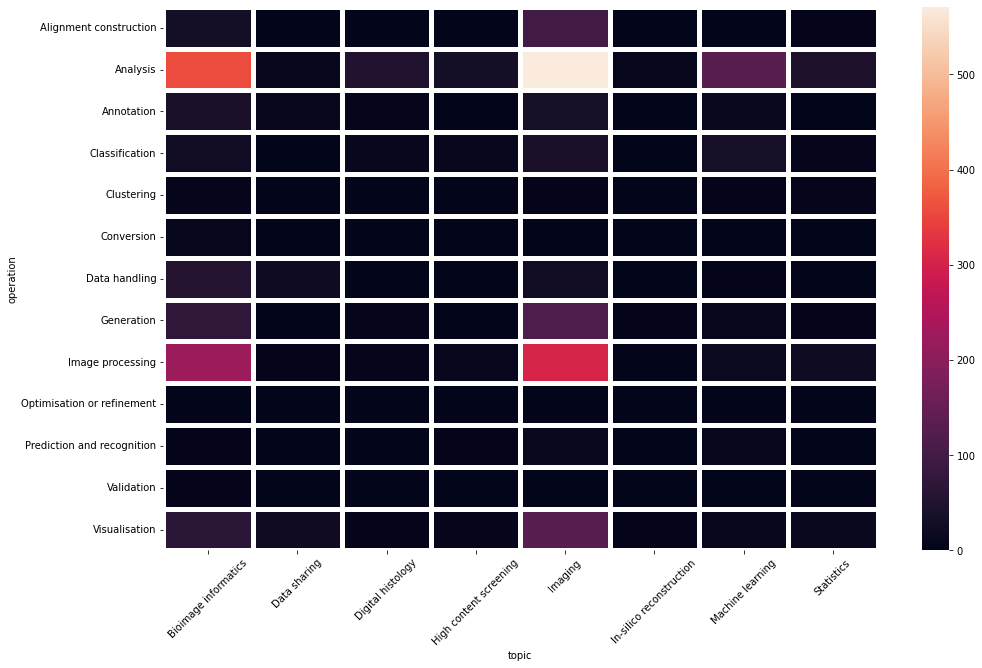

In [46]:
plt.figure(figsize=(16, 10))

df_heatmap = pd.DataFrame(tools) 
df_heatmap
df_heatmap_dum = pd.get_dummies(df_heatmap, columns=['operation', 'topic'])
df_heatmap_dum

df_crosstab = pd.crosstab(df_heatmap['operation'], df_heatmap['topic'])
#df_heatmap_dum.corr()
#sns.heatmap(df_heatmap_dum.corr(), linewidths=.5)
#corr = df_heatmap['operation'].corr(df_heatmap['topic'])
#corr
#sns.heatmap(df_heatmap.corr(), linewidths=.5)
chart = sns.heatmap(df_crosstab, linewidths=5)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)